In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import uproot
from tqdm import trange
from tqdm import tqdm
import matplotlib.patheffects as pe
from scipy.interpolate import interp1d

import NESTModel
from s2widthFast import WidthModel

plt.style.use('style.mplstyle')

In [14]:
S1R = 1.0   # Example S1 rate
S2R = 1.0   # Example S2 rate
D = 140.0   # Drift distance in cm, for example

In [20]:
E_fields = np.linspace(90, 1000, 20)  # 0.9 to 10 kV/cm

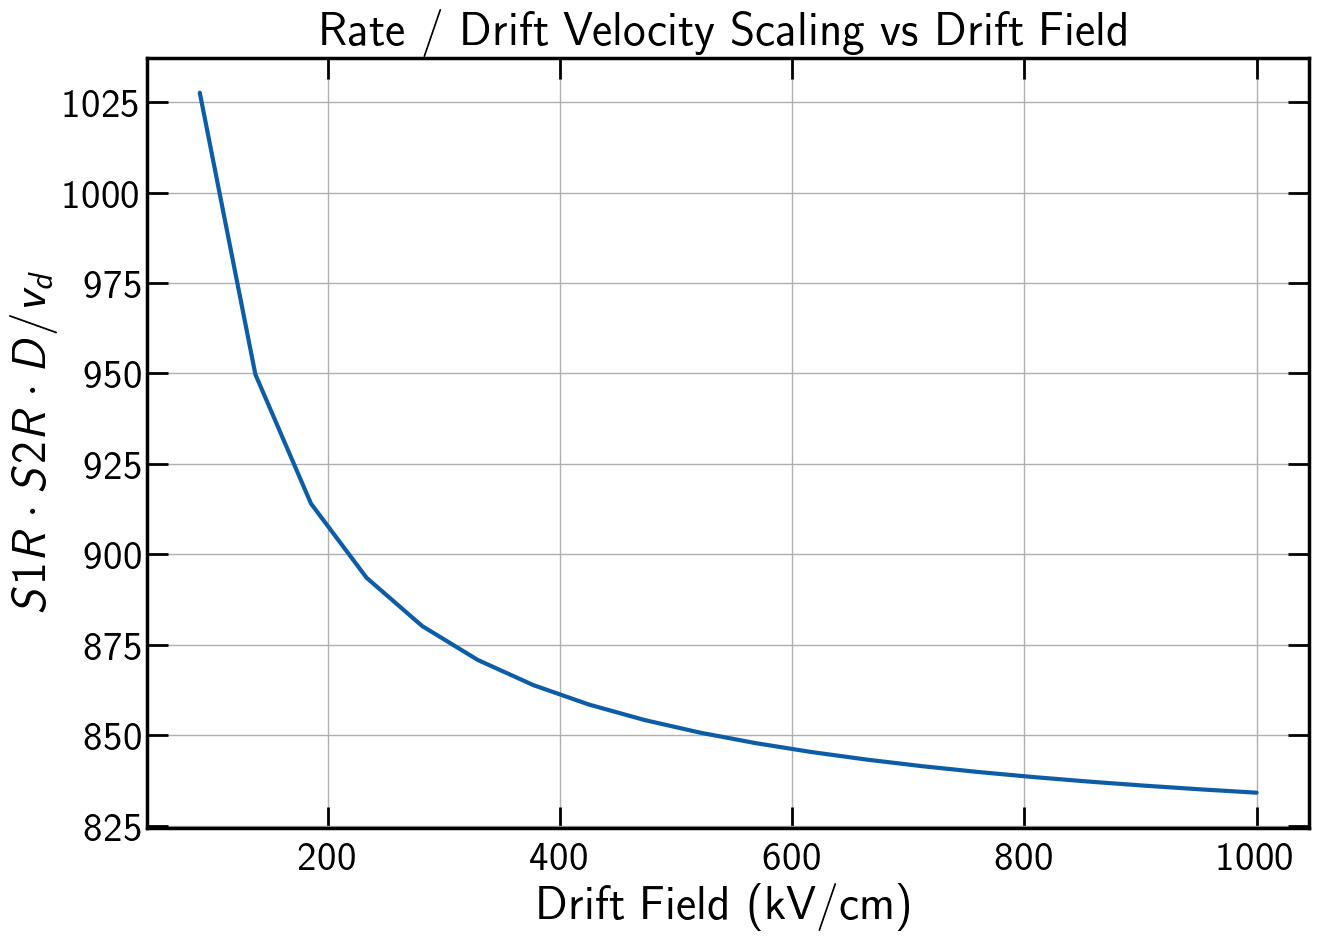

In [21]:
vd_values = np.array([NESTModel.NEST_DV(E) for E in E_fields])  # vd in mm/us or cm/us depending on NEST

quantity = S1R * S2R * D / vd_values

plt.figure()
plt.plot(E_fields, quantity, lw=3)
plt.xlabel("Drift Field (kV/cm)")
plt.ylabel(r"$S1R \cdot S2R \cdot D / v_d$")
plt.title("Rate / Drift Velocity Scaling vs Drift Field")
plt.grid(True)

In [ ]:
# -------------------------------
# Parameters
# -------------------------------
M = 1000000   # number of events per field

accepted_fraction = []

# -------------------------------
# Loop over drift fields
# -------------------------------
for E in tqdm(E_fields, desc="Drift field loop"):
    # Drift velocity
    vd = NESTModel.NEST_DV(E)  # in mm/us
    # Maximum drift time
    T_max = D / vd   # in μs
    
    # Longitudinal diffusion
    DL = NESTModel.NEST_DL(E)  # in mm^2/us

    # -------------------------------
    # Create WidthModel
    # -------------------------------
    model = WidthModel(DL, vd, C=0.0, dC=0.0, p=0.5, numba_Npts=800)

    # Define discrete N values and drift times for 3D PDF
    n_values = np.arange(4, 21)  # example N=4..20
    drift_times = np.linspace(50, T_max, 50)  # discrete times to build PDF
    widths = np.linspace(0, 10000, 200)  # width axis in μs

    # Build 3D PDF
    model.build_pdf_3d(n_values, drift_times, widths)
    # Compute percentiles for cuts
    lower_bounds, upper_bounds = WidthModel.compute_percentile_bounds(model.pdf_3d, model._pdf_widths)
    
    # -------------------------------
    # Generate random N and drift times
    # -------------------------------
    Ns = np.random.choice(n_values, size=M)
    DTs = np.random.uniform(50, T_max, size=M)  # randomized drift time per event

    # Sample widths using the PDF
    Ws = model.sample(Ns, DTs)

    # -------------------------------
    # Check fraction of accepted events
    # -------------------------------
    accepted = np.zeros(M, dtype=bool)
    for i in range(M):
        n_idx = np.argmin(np.abs(model._pdf_n_values - Ns[i]))
        # Interpolate lower and upper bounds to the event's drift time
        lower = np.interp(DTs[i], model._pdf_drift_times, lower_bounds[n_idx, :])
        upper = np.interp(DTs[i], model._pdf_drift_times, upper_bounds[n_idx, :])
        accepted[i] = (Ws[i] >= lower) & (Ws[i] <= upper)

    accepted_fraction.append(np.sum(accepted) / M)

# -------------------------------
# Plot fraction of accepted events vs drift field
# -------------------------------
plt.figure(figsize=(8,5))
plt.plot(E_fields, accepted_fraction, marker='o', lw=2)
plt.xlabel("Drift Field (kV/cm)")
plt.ylabel("Fraction of Accepted Events")
plt.title("Width Cut Acceptance vs Drift Field")
plt.grid(True)
plt.show()


Drift field loop:   0%|                                                                          | 0/20 [00:00<?, ?it/s]

Building 3D PDF:   0%|          | 0/17 [00:00<?, ?it/s]

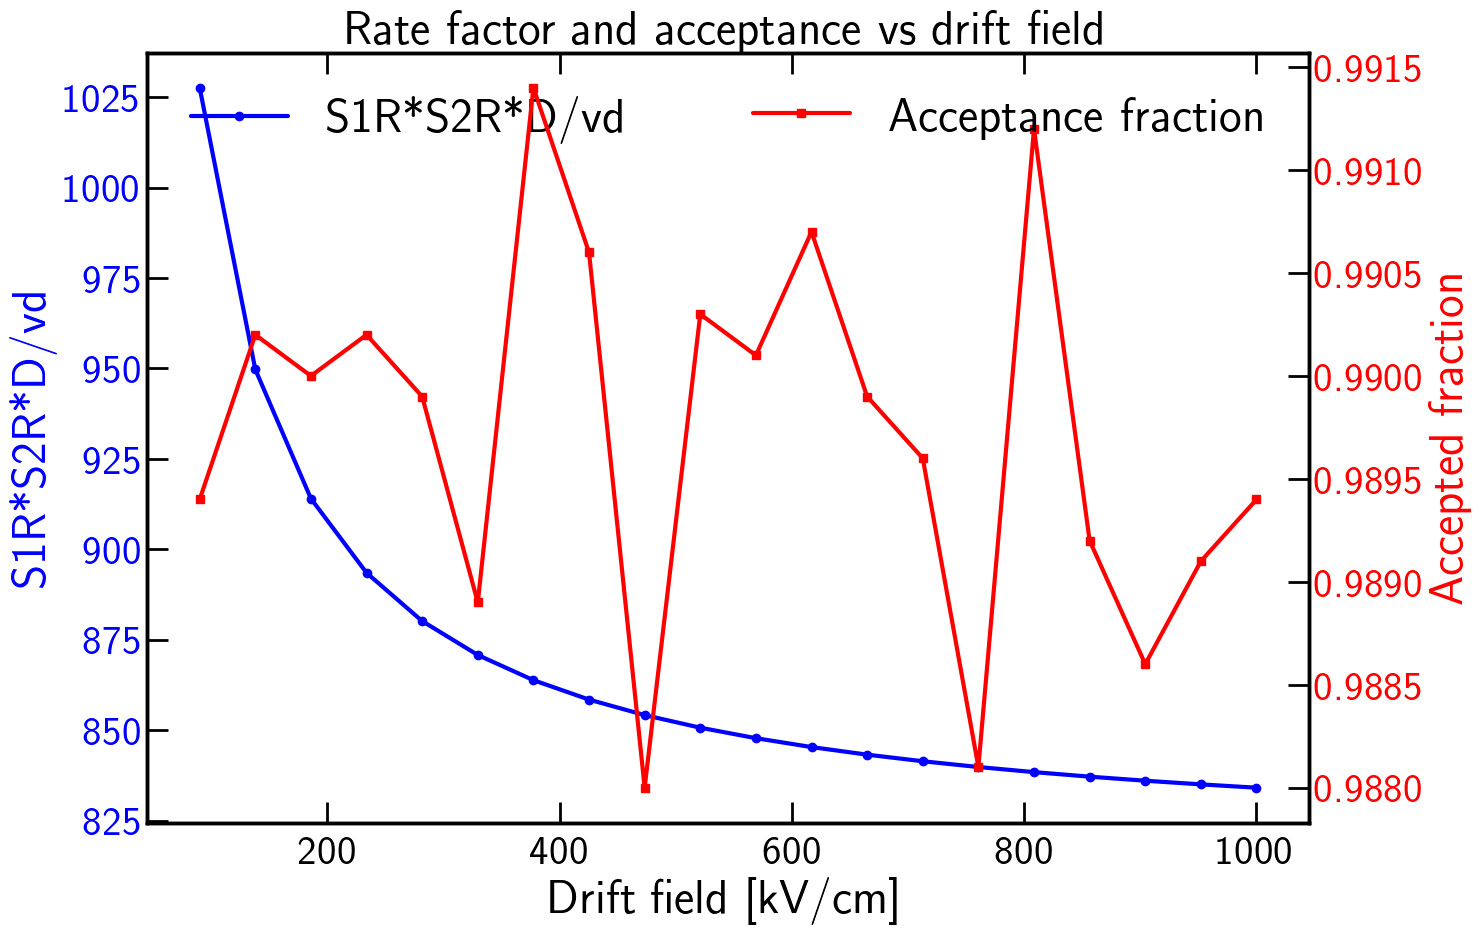

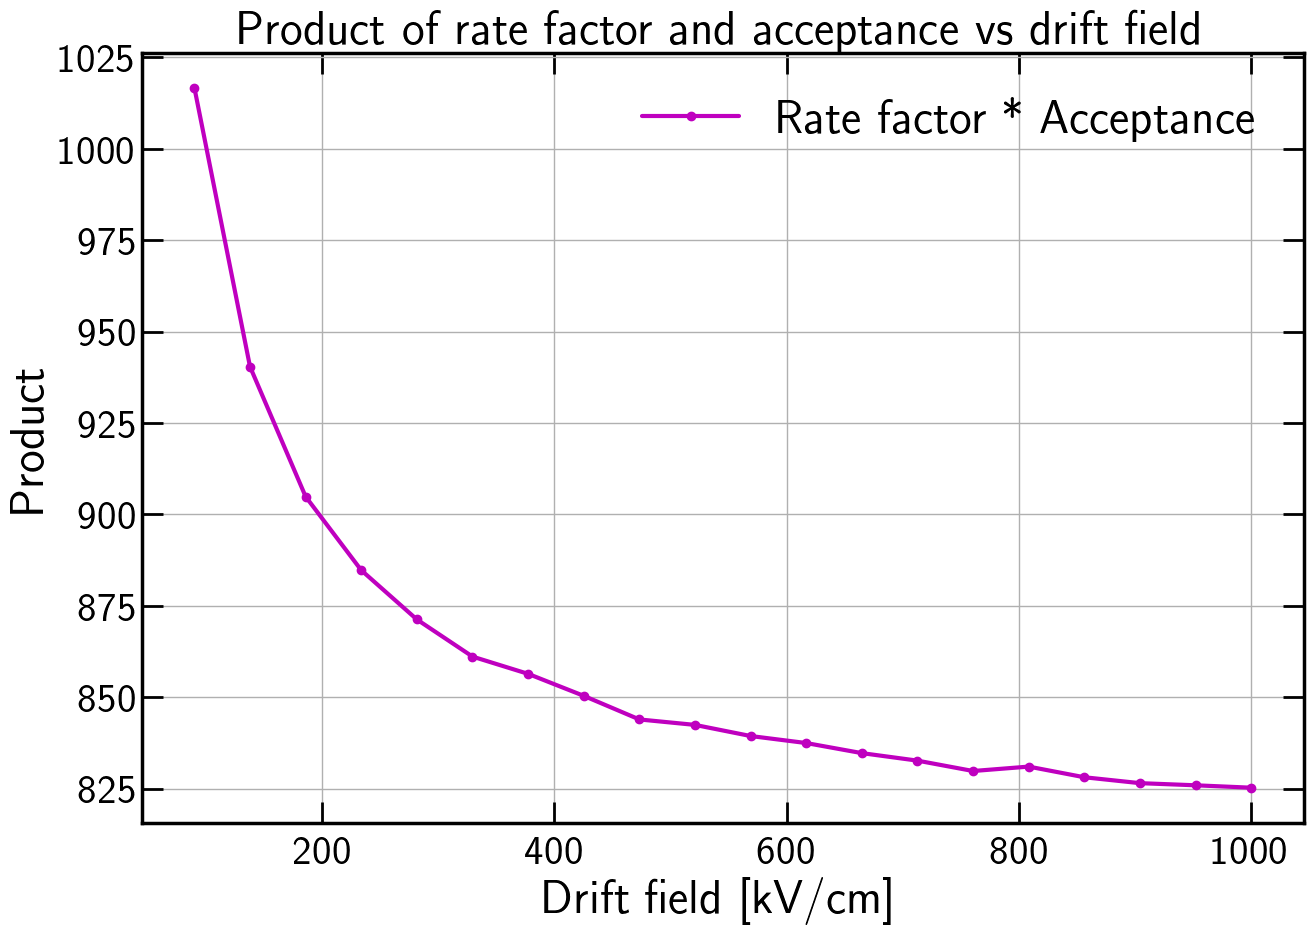

In [28]:
# Compute S1R*S2R*D/vd
rate_factor = S1R * S2R * D / vd_values
product = rate_factor * accepted_fraction

# --- Twin axis plot ---
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(E_fields, rate_factor, 'b-o', label='S1R*S2R*D/vd')
ax2.plot(E_fields, accepted_fraction, 'r-s', label='Acceptance fraction')

ax1.set_xlabel("Drift field [kV/cm]")
ax1.set_ylabel("S1R*S2R*D/vd", color='b')
ax2.set_ylabel("Accepted fraction", color='r')

ax1.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title("Rate factor and acceptance vs drift field")
plt.show()

# --- Separate plot of the product ---
plt.figure()
plt.plot(E_fields, product, 'm-o', label='Rate factor * Acceptance')
plt.xlabel("Drift field [kV/cm]")
plt.ylabel("Product")
plt.title("Product of rate factor and acceptance vs drift field")
plt.grid(True)
plt.legend()
plt.show()